In [1]:
# 1. Các thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression


In [2]:
df = pd.read_csv('BID Historical Data.csv')
df = df[['Price']]
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index

In [3]:
df

,Price
0,19516.3
1,19516.3
2,19057.0
3,19018.8
4,19133.6
...,...
1324,46000.0
1325,46000.0
1326,46200.0
1327,46200.0


In [28]:
# 2. Đọc file dữ liệu chứng khoán AAPL và chia train test validate theo tỉ lệ 7:1:2
df = pd.read_csv('BID Historical Data.csv')
df = df[['Price']]
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index

# Split the data into training, testing, and validation sets
train_size = int(0.7 * len(df))
test_size = int(0.2 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

In [23]:
# # 2. Đọc file dữ liệu chứng khoán AAPL và chia train test validate theo tỉ lệ 7:1:2
# df = pd.read_csv('BID Historical Data.csv')
# #Định dạng lại cột Date từ obj -> datetime
# df['Date'] = pd.to_datetime(df['Date'])
# # Chuyển cột Date làm index để lập biểu đồ so sánh về sau
# df.index = df.Date
# df.drop('Date', axis=1, inplace=True)
# df = df[['Price']]

# # Split the data into training, testing, and validation sets
# train_size = int(0.7 * len(df))
# test_size = int(0.2 * len(df))
# val_size = len(df) - train_size - test_size

# train_data = df[:train_size]
# test_data = df[train_size:train_size+test_size]
# val_data = df[train_size+test_size:]

In [29]:
# 3. Quá trình Training
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Price'])

# Find the best ARIMA model using auto_arima
from pmdarima.arima import auto_arima
model = auto_arima(y_train, trace=True, error_action='ignore', suppress_warnings=True)

# Fit the model
model.fit(y_train)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=14879.674, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=14873.437, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=14875.395, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=14875.405, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=14871.717, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=14877.424, Time=0.11 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.441 seconds


ARIMA(order=(0, 1, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [30]:
# 4. Quá trình testing 
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Price'])
y_pred = model.predict(n_periods=len(y_test))

# 5. Quá trình Validate
x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['Price'])
y_pred_val =  model.predict(n_periods=len(y_val))

In [31]:
# 6. Quá trình tạo index predict 30 ngày tiếp theo
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

# Create an array of 30 consecutive integers starting from last_index
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

# Predict the closing prices for the next 30 days
y_next_30_days = model.predict(n_periods=len(x_next_30_days))

# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
[31182.3 31182.3 31182.3 31182.3 31182.3 31182.3 31182.3 31182.3 31182.3
 31182.3 31182.3 31182.3 31182.3 31182.3 31182.3 31182.3 31182.3 31182.3
 31182.3 31182.3 31182.3 31182.3 31182.3 31182.3 31182.3 31182.3 31182.3
 31182.3 31182.3 31182.3]


In [32]:
# 7. Đánh giá độ chính xác validate, test
valid_rmse = np.sqrt(np.mean((y_pred_val - y_val)**2))
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)


Validation RMSE: 9958.619554900857
Testing RMSE: 7485.89439849349


Validation RMSE: 9958.619554900857
Testing RMSE: 7485.89439849349

Validation MAPE: 0.20177359712722823
Testing MAPE: 0.14500739599838947


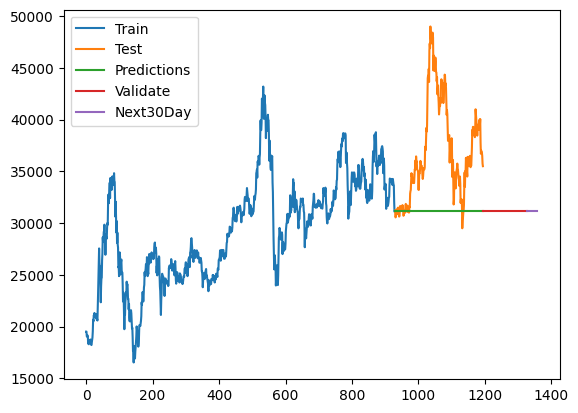

In [36]:
# 8. Tính RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - y_val)**2))
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

# 8.1 Tính MAPE
valid_mape = np.mean(np.abs(y_pred_val - y_val)/np.abs(y_val))
test_mape = np.mean(np.abs(y_pred - y_test)/np.abs(y_test))
print('\nValidation MAPE:', valid_mape)
print('Testing MAPE:', test_mape)

# 9.Vẽ hình
plt.plot(train_data.index, train_data['Price'])
plt.plot(test_data.index, test_data['Price'])
plt.plot(test_data.index, y_pred)
plt.plot(val_data.index, y_pred_val)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Predictions','Validate','Next30Day'])
plt.show()

In [37]:
test_data.index

RangeIndex(start=930, stop=1195, step=1)